# Data Collection

In [86]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
df = yf.download('^GSPC', start='1998-01-01')       # ^GSPC is S&P 500 ticker

In [88]:
df.to_csv('SP500.csv')

In [89]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1998-01-02,975.039978,975.039978,965.729980,970.429993,366730000
1998-01-05,977.070007,982.630005,969.000000,975.039978,628070000
1998-01-06,966.580017,977.070007,962.679993,977.070007,618360000
1998-01-07,964.000000,966.580017,952.669983,966.580017,667390000
1998-01-08,956.049988,964.000000,955.039978,964.000000,652140000


In [92]:
df.tail()

,close,high,low,open,volume
Date,,,,,
2025-06-13,5976.970215,6026.160156,5963.209961,6000.560059,5258910000
2025-06-16,6033.109863,6050.830078,6004.000000,6004.000000,5111710000
2025-06-17,5982.720215,6023.250000,5974.799805,6012.149902,4955700000
2025-06-18,5980.870117,6018.250000,5971.890137,5987.930176,5106470000
2025-06-20,5960.609863,6018.200195,5952.560059,5999.669922,2185291000


In [94]:
# Fix for MultiIndex columns (flatten the column structure)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]         # Take 1st level of MultiIndex

# Convert to lowercase
df.columns = df.columns.str.lower()

In [95]:
df.head()

,close,high,low,open,volume
Date,,,,,
1998-01-02,975.039978,975.039978,965.729980,970.429993,366730000
1998-01-05,977.070007,982.630005,969.000000,975.039978,628070000
1998-01-06,966.580017,977.070007,962.679993,977.070007,618360000
1998-01-07,964.000000,966.580017,952.669983,966.580017,667390000
1998-01-08,956.049988,964.000000,955.039978,964.000000,652140000


In [96]:
# Stock price prediction using 'Close' column
df1 = df.reset_index()['close']

In [97]:
df1.shape

(6909,)

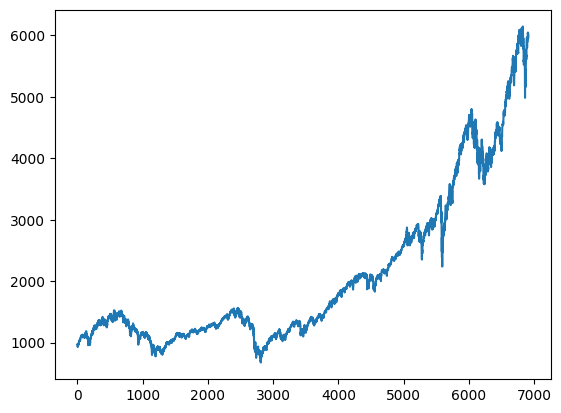

In [98]:
# Plot historic stock price
import matplotlib.pyplot as plt

plt.plot(df1)

In [99]:
# LSTM are sensitive to scale of data, so we appply MinMax Scalar
from sklearn.preprocessing import MinMaxScaler 

# Scale down to (0, 1)
scaler = MinMaxScaler(feature_range = (0, 1))

df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [100]:
df1.shape

(6909, 1)

In [101]:
print(df1)

[[0.05459596]
 [0.05496724]
 [0.05304867]
 ...
 [0.97047533]
 [0.97013695]
 [0.96643146]]


In [102]:
# Splitting dataset into train and test split
training_size = int(len(df1) * 0.80)                # 80% of dataset goes for training 

test_size = len(df1) - training_size            # Remaining dataset goes for testing

train_data, test_data = df1[0 : training_size, :], df1[training_size : len(df1), : 1]

In [103]:
training_size, test_size

(5527, 1382)

In [104]:
len(train_data), len(test_data)

(5527, 1382)

In [105]:
train_data

array([[0.05459596],
       [0.05496724],
       [0.05304867],
       ...,
       [0.45996612],
       [0.46016183],
       [0.45990942]], shape=(5527, 1))

# Data Preprocessing 

In [106]:
# Convert an array of values into a dataset matrix 
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []

    for i in range(len(dataset) - time_step - 1):
        a = dataset[i : (i+ time_step), 0]          # i = 0, 1, 2, 3, ...
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])

    return np.array(dataX), np.array(dataY)
    

In [107]:
print(f"Train data length: {len(train_data)}, Test data length: {len(test_data)}")

time_step = min(30, len(test_data) // 4)  # Conservative approach

print(f"Using time_step: {time_step}")

Train data length: 5527, Test data length: 1382
Using time_step: 30


In [108]:
# Reshape into X = t, t+1, t+2, t+3 and Y = t+4
time_step = 60

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [109]:
print(X_train)

[[0.05459596 0.05496724 0.05304867 ... 0.07759684 0.0766165  0.07627998]
 [0.05496724 0.05304867 0.0525768  ... 0.0766165  0.07627998 0.07777058]
 [0.05304867 0.0525768  0.05112279 ... 0.07627998 0.07777058 0.07894111]
 ...
 [0.42619276 0.42350055 0.42344751 ... 0.44918814 0.45085429 0.45578151]
 [0.42350055 0.42344751 0.41884222 ... 0.45085429 0.45578151 0.45582357]
 [0.42344751 0.41884222 0.42218372 ... 0.45578151 0.45582357 0.45996612]]


In [110]:
print(X_train.shape), print(y_train.shape)

(5466, 60)
(5466,)


(None, None)

In [111]:
print(X_test.shape), print(y_test.shape)

(1321, 60)
(1321,)


(None, None)

In [112]:
# Reshape I/P to be [samples, time steps, features] which is req for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


## Create Stacked LSTM model

In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input   
from tensorflow.keras.layers import Dropout         # For better generalisation

In [114]:
model = Sequential([
    Input(shape=(60, 1)),           # time_step = 60
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

In [115]:
model.compile(
    loss = 'mean_squared_error', 
    optimizer = 'adam',
    metrics=['mae', 'mse', 'mape']
)

In [116]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 15,                       # Wait for 15 epochs without improvement
    restore_best_weights = True          # Load the BEST model weights
)       

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor = 'val_loss',
    save_best_only = True,
    save_weights_only = False
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 10,
    min_lr = 0.0001
)

# Enhanced training
history = model.fit(
    X_train, y_train, 
    validation_data = (X_test, y_test), 
    epochs = 50, 
    batch_size = 64, 
    verbose = 1,
    callbacks = [early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0050 - mae: 0.0452 - mape: 18221.2285 - mse: 0.0050 - val_loss: 6.8808e-04 - val_mae: 0.0197 - val_mape: 3.0291 - val_mse: 6.8808e-04 - learning_rate: 0.0010
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 3.8135e-04 - mae: 0.0136 - mape: 23203.3496 - mse: 3.8135e-04 - val_loss: 9.5249e-04 - val_mae: 0.0241 - val_mape: 3.4669 - val_mse: 9.5249e-04 - learning_rate: 0.0010
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 3.1847e-04 - mae: 0.0125 - mape: 1078.4202 - mse: 3.1847e-04 - val_loss: 0.0038 - val_mae: 0.0536 - val_mape: 7.5094 - val_mse: 0.0038 - learning_rate: 0.0010
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 3.6323e-04 - mae: 0.0131 - mape: 3449.5159 - mse: 3.6323e-04 - val_loss: 0.0017 - val_mae: 0.0326 - val_mape: 4.5104 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 2.5857e-04 - mae: 0.0110 - mape: 5398.5332 - mse: 2.5857e-0

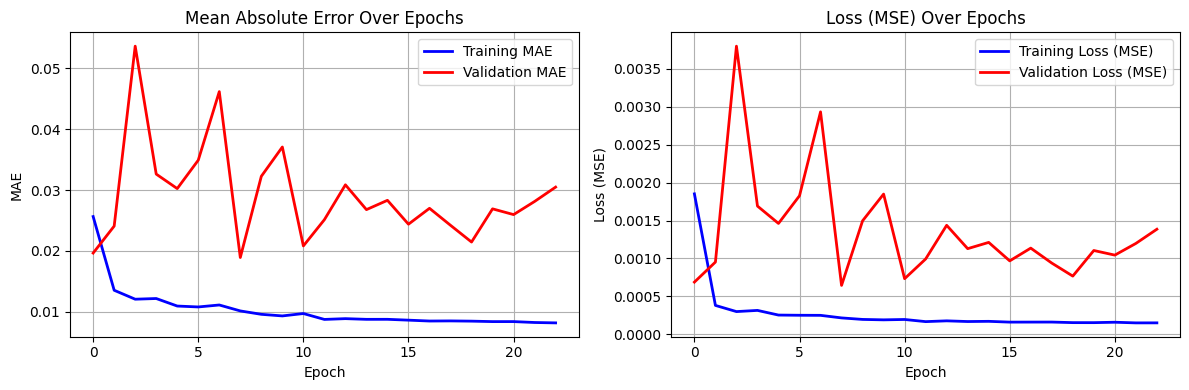

In [120]:
plt.figure(figsize=(12, 4))

# Plot MAE
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Training MAE', color='blue', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', color='red', linewidth=2)
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Plot Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss (MSE)', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', color='red', linewidth=2)
plt.title('Loss (MSE) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Prediction

In [121]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [122]:
# Tranform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [123]:
# Calculate RMSE performance metrics 
import math

from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(y_train, train_predict))

1669.5980855985958

In [124]:
# Test data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

4527.677989816647

# Plotting

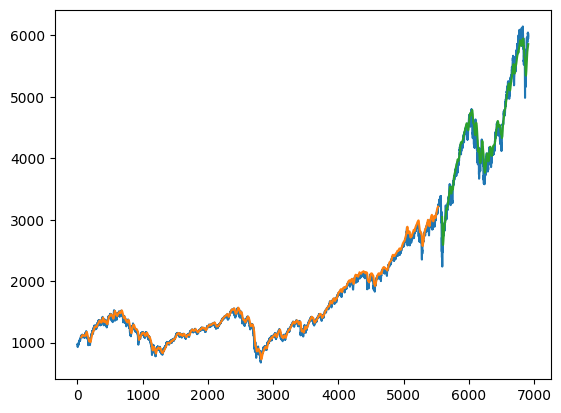

In [125]:
# Shift train predictions for plotting
look_back = 60

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back: len(train_predict) + look_back, :] = train_predict

# Shift test predictions for plotting 
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(df1) - 1, :] = test_predict

# Plot baseline & predictions 
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [126]:
len(test_data)

1382

In [127]:
x_input = test_data[822:].reshape(1, -1)
x_input.shape

(1, 560)

In [128]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [129]:
temp_input

[0.6025912676329408,
 0.6129321545956975,
 0.6171423996503563,
 0.6278380920771529,
 0.6306180415586775,
 0.6262450843078241,
 0.624375858743309,
 0.6270534656469857,
 0.6278014773678007,
 0.6277703995169359,
 0.6246630162992165,
 0.6345887728316714,
 0.633019519971337,
 0.6355214655742921,
 0.6361707961881944,
 0.6361067650989126,
 0.6315837768438843,
 0.6322659713920346,
 0.6329097651474495,
 0.6209465786478822,
 0.6180861214578673,
 0.6326006834180152,
 0.6388428662333837,
 0.6385484303876904,
 0.6297164266669215,
 0.624443551303526,
 0.6190426584136517,
 0.6327652710017619,
 0.6331073059696131,
 0.629641411164834,
 0.633019519971337,
 0.6317355939314423,
 0.6305394538898239,
 0.6327707185560801,
 0.6279459715134882,
 0.6368840685872094,
 0.6440681424746212,
 0.6429580023478959,
 0.6430768661970369,
 0.6344716950659134,
 0.6289226912115008,
 0.6355141426324217,
 0.645421636462285,
 0.6454344069584736,
 0.6407358467068931,
 0.6482692785040266,
 0.6594899008370971,
 0.6579206479767628

# Prediction for the next 30 days 

In [130]:
from numpy import array

In [131]:
lst_output = []
n_steps = 60                # Equal to time_steps
i = 0

In [132]:
while(i < 30):
    
    if(len(temp_input) > 60):               # time_step = 60

        # Take only the LAST 60 elements, not all elements from index 1
        x_input = np.array(temp_input[-60:])            # Fixed: last 60 elements
        
        print("{} day input {}".format(i, x_input.shape))
        
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        print("{} day output {}".format(i, yhat))
        
        temp_input.append(yhat[0][0])
        
        lst_output.append(yhat[0][0])
        i = i + 1

    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))

        yhat = model.predict(x_input, verbose=0)

        print(yhat[0])

        temp_input.append(yhat[0][0])

        lst_output.append(yhat[0][0])
        i = i + 1

print(lst_output)

0 day input (60,)
0 day output [[0.9495036]]
1 day input (60,)
1 day output [[0.95001775]]
2 day input (60,)
2 day output [[0.9501003]]
3 day input (60,)
3 day output [[0.94978374]]
4 day input (60,)
4 day output [[0.9491329]]
5 day input (60,)
5 day output [[0.9482217]]
6 day input (60,)
6 day output [[0.94712114]]
7 day input (60,)
7 day output [[0.9458919]]
8 day input (60,)
8 day output [[0.94458246]]
9 day input (60,)
9 day output [[0.9432293]]
10 day input (60,)
10 day output [[0.9418591]]
11 day input (60,)
11 day output [[0.9404894]]
12 day input (60,)
12 day output [[0.93913186]]
13 day input (60,)
13 day output [[0.93779314]]
14 day input (60,)
14 day output [[0.93647677]]
15 day input (60,)
15 day output [[0.93518513]]
16 day input (60,)
16 day output [[0.93391705]]
17 day input (60,)
17 day output [[0.9326739]]
18 day input (60,)
18 day output [[0.93145347]]
19 day input (60,)
19 day output [[0.9302558]]
20 day input (60,)
20 day output [[0.9290794]]
21 day input (60,)
21 d

In [133]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

In [135]:
len(df1)

6909

In [136]:
df3 = df1.tolist()
df3.extend(lst_output)

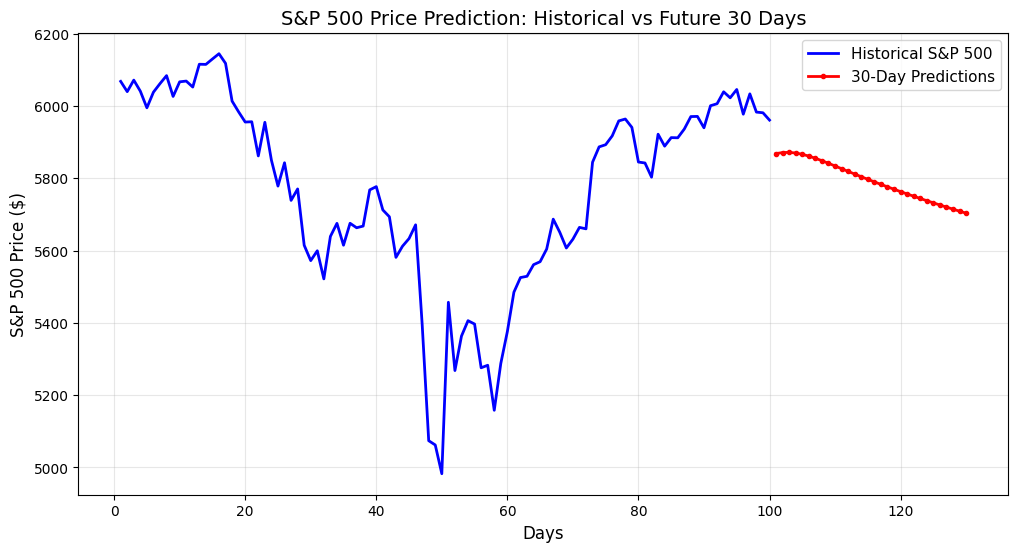

In [137]:
plt.figure(figsize=(12, 6))

# Plot historical data (last 100 days)
plt.plot(day_new, scaler.inverse_transform(df1[6809:]), 
         label='Historical S&P 500', color='blue', linewidth=2)

# Plot future predictions (next 30 days)
plt.plot(day_pred, scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)), 
         label='30-Day Predictions', color='red', linewidth=2, marker='o', markersize=3)

plt.title('S&P 500 Price Prediction: Historical vs Future 30 Days', fontsize=14)
plt.xlabel('Days', fontsize=12)
plt.ylabel('S&P 500 Price ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

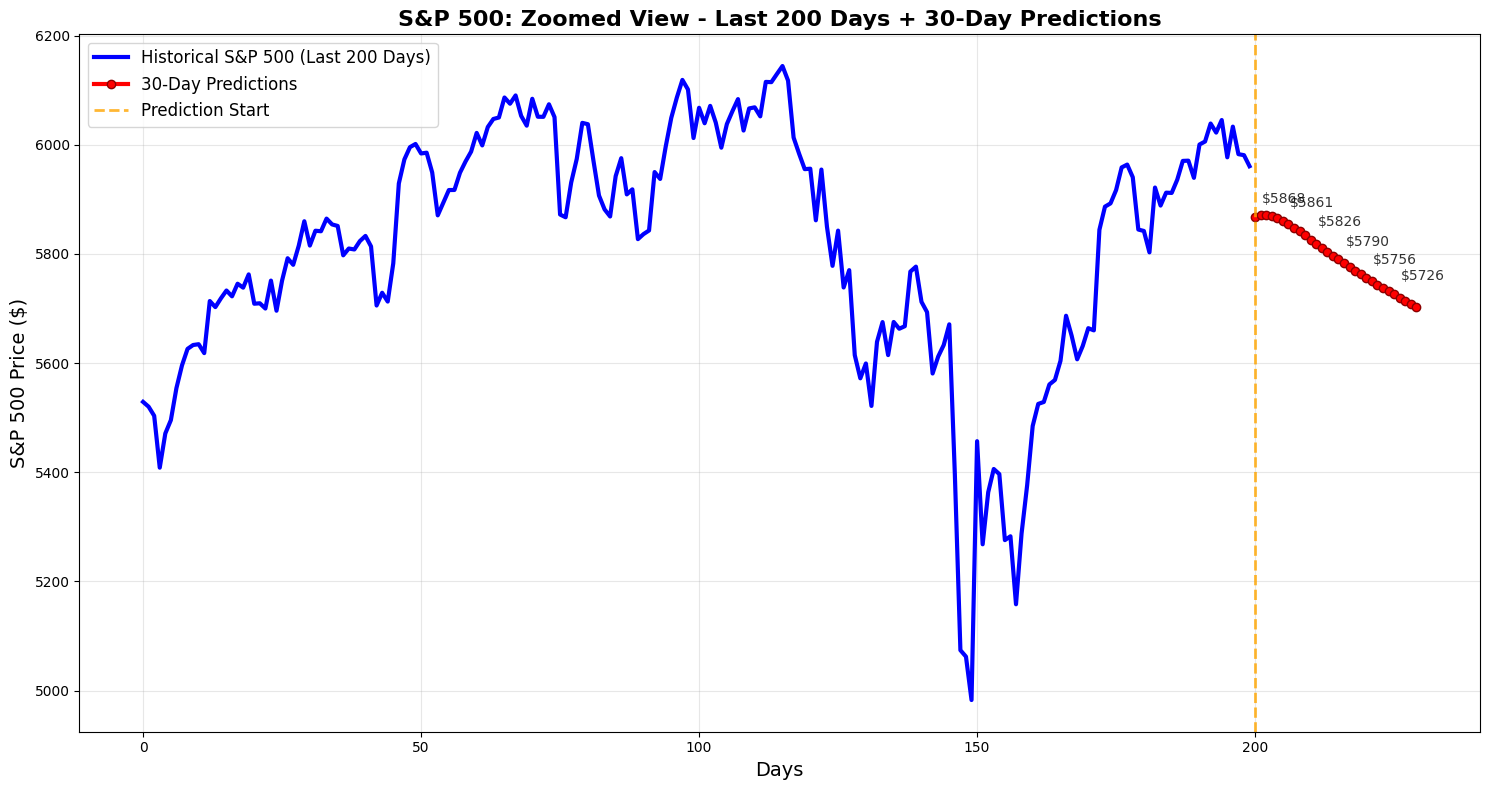

In [ ]:
plt.figure(figsize=(15, 8))

# Last 200 historical days + 30 predictions
zoom_start = max(0, historical_end - 200)
historical_zoom = df3_scaled[zoom_start:historical_end]
predictions_zoom = df3_scaled[historical_end:]

# Plot historical data (last 200 days)
plt.plot(range(200), historical_zoom, 
         linewidth=3, color='blue', label='Historical S&P 500 (Last 200 Days)')

# Plot predictions (next 30 days)
plt.plot(range(200, 230), predictions_zoom, 
         linewidth=3, color='red', marker='o', markersize=6, 
         label='30-Day Predictions', markerfacecolor='red', markeredgecolor='darkred')

# Add vertical line at prediction start
plt.axvline(x=200, color='orange', linestyle='--', linewidth=2, alpha=0.8, 
           label='Prediction Start')

# Enhanced styling
plt.title('S&P 500: Zoomed View - Last 200 Days + 30-Day Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Days', fontsize=14)
plt.ylabel('S&P 500 Price ($)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)

for i, val in enumerate(predictions_zoom[::5]):         # Annotate every 5th prediction
    plt.annotate(f'${val[0]:.0f}',
                xy=(200 + i*5, val[0]), 
                xytext=(5, 10), textcoords='offset points',
                fontsize=10, alpha=0.8)

plt.tight_layout()
plt.show()

In [143]:
# Calculate comprehensive metrics for resume
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Transform back to original scale for accurate metrics
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate professional metrics
train_mae = mean_absolute_error(y_train_original, train_predict)
test_mae = mean_absolute_error(y_test_original, test_predict)
train_rmse = np.sqrt(mean_squared_error(y_train_original, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_original, test_predict))
test_r2 = r2_score(y_test_original, test_predict)

# MAPE calculation
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

train_mape = calculate_mape(y_train_original, train_predict)
test_mape = calculate_mape(y_test_original, test_predict)

print("=== RESUME-READY METRICS ===")
print(f"Model Accuracy (R² Score): {test_r2:.3f}")
print(f"Prediction Error (MAE): ${test_mae:.2f}")
print(f"Error Percentage (MAPE): {test_mape:.2f}%")
print(f"Root Mean Square Error: ${test_rmse:.2f}")
print(f"Training Efficiency: {train_mape:.2f}% error")

=== RESUME-READY METRICS ===
Model Accuracy (R² Score): 0.972
Prediction Error (MAE): $103.48
Error Percentage (MAPE): 2.41%
Root Mean Square Error: $138.82
Training Efficiency: 2.22% error
